# Question A4

In this section, we will understand the utility of such a neural network in real world scenarios.

#### Please use the real record data named ‘record.wav’  as a test sample. Preprocess the data using the provided preprocessing script (data_preprocess.ipynb) and prepare the dataset.
Do a model prediction on the sample test dataset and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons.
Find the most important features on the model prediction for the test sample using SHAP. Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5,
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195)



1. Firstly, we import relevant libraries.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

To reduce repeated code, place your
network (MLP defined in QA1)
torch datasets (CustomDataset defined in QA1)
loss function (loss_fn defined in QA1)
in a separate file called common_utils.py

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.


In [2]:
# YOUR CODE HERE
from common_utils import MLP, CustomDataset, loss_fn, split_dataset, preprocess_dataset, EarlyStopper

2. Install and import shap

In [3]:
# YOUR CODE HERE
!pip install shap

In [4]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


3. Read the csv data preprocessed from 'record.wav', using variable name 'df', and fill the size of 'df' in 'size_row' and 'size_column'.

In [5]:
# df = 0
size_row = 0
size_column = 0
# YOUR CODE HERE
df = pd.read_csv('new_record.csv')
size_row, size_column = df.shape

print(f"Before dropping 'filename' column:\n\tsize_row: {size_row}\tsize_column: {size_column}")


# Importing training data from simplified.csv
simplified = pd.read_csv('simplified.csv')
simplified['label'] = simplified['filename'].str.split('_').str[-2]
simplified['label'].value_counts()

label_encoder = preprocessing.LabelEncoder()

simplified['label'] = label_encoder.fit_transform(simplified['label'])
X = simplified.drop(['filename', 'label'], axis=1)
y = simplified['label'].to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1)

Before dropping 'filename' column:
	size_row: 1	size_column: 78


 4.  Preprocess to obtain the test data, save the test data as numpy array.

In [6]:

def preprocess(X_train, df):
    """preprocess your dataset to obtain your test dataset, remember to remove the 'filename' as Q1
    """
    # YOUR CODE HERE
    # Prepping test dataset
    X_test = df.drop('filename', axis=1)
    X_train_scaled, X_test_scaled_eg = preprocess_dataset(X_train, X_test)
    return X_test_scaled_eg


X_test_scaled_eg = preprocess(X_train, df)
X_train_scaled, X_val_scaled = preprocess_dataset(X_train, X_val)

5. Do a model prediction on the sample test dataset and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. Note: Please define the variable of your final predicted label as 'pred_label'.

In [7]:
# YOUR CODE HERE
no_features = 77
no_hidden = 256
no_labels = 2

batch_size = 1024
no_epochs = 100
lr = 0.001

model = MLP(no_features, no_hidden, no_labels)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# loss_fn is imported
early_stopper = EarlyStopper(patience=3, min_delta=0.00005)

def dataloader_maker(mini_x, mini_y, batch_size, shuffle):
    """
    This function is to take the x_train / x_val and y_train / y_val and convert it to a DataLoader object with its batch sizes.
    """
    data = CustomDataset(mini_x, mini_y)
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=shuffle)
    return dataloader

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        pred = model(torch.tensor(X, dtype=torch.float))
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= size
    correct /= size
    return train_loss, correct

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    return test_loss, correct

train_dataloader = dataloader_maker(X_train_scaled, y_train, batch_size, True)
val_dataloader = dataloader_maker(X_val_scaled, y_val, batch_size, True)
train_loss_, train_acc_ = [], []
val_loss_, val_acc_ = [], []
for epoch in range(no_epochs):
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    val_loss, val_acc = test(val_dataloader, model, loss_fn)
    train_loss_.append(train_loss), train_acc_.append(train_acc)
    val_loss_.append(val_loss), val_acc_.append(val_acc)
    if epoch % 5 == 0:
        print(f"Epoch: {epoch}\n\ttrain_loss: {train_loss}\ttrain_acc: {train_acc}")
        print(f"\tval_loss: {val_loss}\t\tval_acc: {val_acc}")

    if early_stopper.early_stop(val_loss):
            print(f"Early Stop occur at epoch {epoch}")
            break

pred = model(torch.tensor(X_test_scaled_eg, dtype=torch.float))
pred_label = pred.argmax(1).item()
print(f"Predicted label: {pred_label}")


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 0
	train_loss: 0.0007348397371681088	train_acc: 0.5170043844057353
	val_loss: 0.0007599185454113962		val_acc: 0.5422885572139303
Epoch: 5
	train_loss: 0.0006875548971279889	train_acc: 0.6318284156890627
	val_loss: 0.0007297072771703953		val_acc: 0.6158098396904367
Epoch: 10
	train_loss: 0.0006450510219963174	train_acc: 0.6885886953430501
	val_loss: 0.0007057780716022515		val_acc: 0.6354339414040907
Epoch: 15
	train_loss: 0.0006020317104193593	train_acc: 0.7340917170280838
	val_loss: 0.0006788865580224016		val_acc: 0.6746821448313985
Epoch: 20
	train_loss: 0.0005732525763798132	train_acc: 0.7664415215072876
	val_loss: 0.0006775414172689713		val_acc: 0.6782752902155887
Epoch: 25
	train_loss: 0.0005409986801319233	train_acc: 0.7979618438203578
	val_loss: 0.0006616247695345059		val_acc: 0.6937534549474847
Epoch: 30
	train_loss: 0.0005358033785394532	train_acc: 0.805308685863254
	val_loss: 0.0006554607794125348		val_acc: 0.6998341625207297
Epoch: 35
	train_loss: 0.0005072223262942816

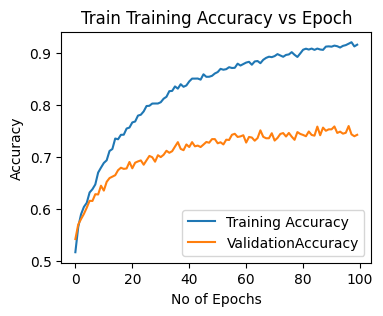

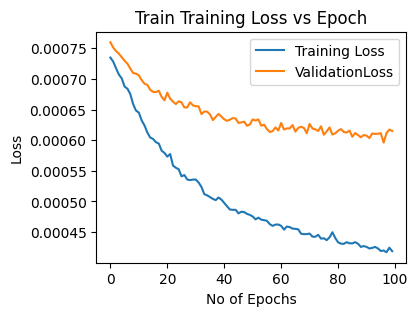

In [8]:
def plot(no_epochs, training_data, validation_data, label):
    fig = plt.figure(figsize=(4, 3))
    plt.plot(range(no_epochs), training_data, label=label)
    plt.plot(range(no_epochs), validation_data, label="Validation" + label.split(" ")[1])
    plt.xlabel('No of Epochs')
    plt.ylabel(label.split(" ")[1])
    plt.title(f'Train {label} vs Epoch')
    plt.legend()
    plt.show()

plot(no_epochs, train_acc_, val_acc_, "Training Accuracy")
plot(no_epochs, train_loss_, val_loss_, "Training Loss")

6. Find the most important features on the model prediction for your test sample using SHAP. Create an instance of the DeepSHAP which is called DeepExplainer using traianing dataset: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html.

Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5,
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195)


In [9]:
df = df.drop('filename', axis=1)

In [10]:
'''
Fit the explainer on a subset of the data (you can try all but then gets slower)
Return approximate SHAP values for the model applied to the data given by X.
Plot the local feature importance with a force plot and explain your observations.
'''
# YOUR CODE HERE
explainer = shap.DeepExplainer(model, torch.tensor(X_train_scaled, dtype=torch.float))
shap_values = explainer.shap_values(torch.tensor(X_test_scaled_eg, dtype=torch.float))

# X_test = torch.tensor(X_test_scaled_eg).detach().numpy()


explanation = """
In force plot, we can see the effect each feature has on the predicted output.
In this plot, the red features are the features that positively affect the output which pushes our score higher,
whereas the blue features are the features that negatively affect the output which pushes our score lower.
From our force plot, we can see that the feature that affects our class prediction the most belongs to "spec_bw_var" in blue.
"""

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [11]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], features=list(df.columns))

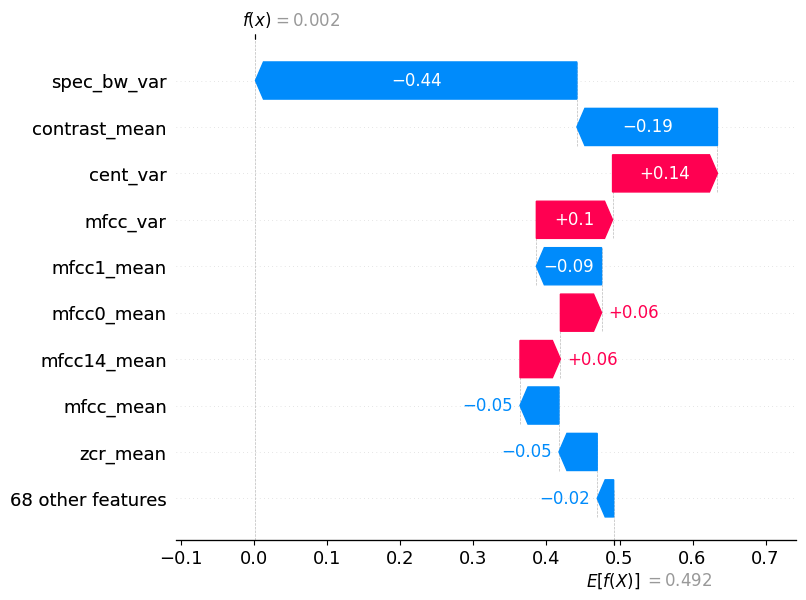

In [12]:
shap.initjs()
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][0], feature_names = list(df.columns))